In [3]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,VotingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [4]:
#loading data 
test = pd.read_csv('test.csv', dtype={'ID': 'int32', 'shop_id': 'int8', 
                                                  'item_id': 'int16'})
cats = pd.read_csv('item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int16'})
items = pd.read_csv('items.csv', dtype={'item_name': 'str', 'item_id': 'int16', 
                                                 'item_category_id': 'int16'})
shops = pd.read_csv('shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int8'})
sales = pd.read_csv('sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

Data Cleaning start

In [5]:
print(cats.shape)
cats.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
# Checking for missing values in Item category data 

In [7]:
cats.isnull().sum()

item_category_name    0
item_category_id      0
dtype: int64

In [8]:
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
# Checking for missing values in items
items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [10]:
import plotly.express as px                                          

fig = px.histogram(items, x = "item_category_id",
                  labels = {"item_category_id":"Category_id"},
                  title = "Item_Category_Id",
                  color_discrete_sequence = ["Orange"]
                  )
                  
fig.show()

In [11]:
print(sales.shape)
sales.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1
1,2013-03-01,0,25,2552,899.00,1
2,2013-05-01,0,25,2552,899.00,-1
3,2013-06-01,0,25,2554,1709.05,1
4,2013-01-15,0,25,2555,1099.00,1


In [12]:
# Checking for missing values in sales.
sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

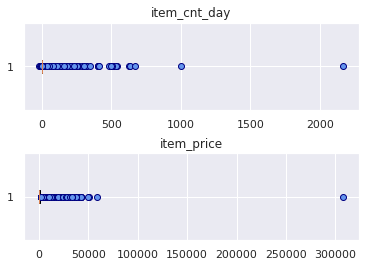

In [13]:
fig, axes = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.5)

flierprops = dict(marker='o', markerfacecolor='cornflowerblue', markersize=6, markeredgecolor='navy')

_ = axes[0].boxplot(x=sales.item_cnt_day, flierprops=flierprops, vert=False)
_ = axes[1].boxplot(x=sales.item_price, flierprops=flierprops, vert=False)

_ = axes[0].set_title('item_cnt_day')
_ = axes[1].set_title('item_price')

In [14]:
print(shops.shape)
shops.head()

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [15]:
# Checking for null data in shops.
shops.isnull().sum()

shop_name    0
shop_id      0
dtype: int64

In [16]:
print('Min date from sales data set: %s' % sales['date'].min().date())
print('Max date from sales data set: %s' % sales['date'].max().date())

Min date from sales data set: 2013-01-01
Max date from sales data set: 2015-12-10


In [17]:
#Adding year and month in sales
sales['year'] = sales['date_block_num'].apply(lambda x: ((x//12) + 2013))
sales['month'] = sales['date_block_num'].apply(lambda x: (x % 12))

In [18]:
#Adding revenue 
sales['revenue'] = sales['item_price'] *  sales['item_cnt_day']

In [19]:
#Filtering based on outliers.
sales = sales[sales.item_price<100000]
sales = sales[sales.item_cnt_day<1001]

    date_block_num  year  month  item_cnt_month
0                0  2013      2          131479
1                1  2013      2          128090
2                2  2013      3          147142
3                3  2013      4          107190
4                4  2013     10          106970
5                5  2013      6          125381
6                6  2013      7          116966
7                7  2013      8          125291
8                8  2013      9          133332
9                9  2013     12          127541
10              10  2013      6          130009
11              11  2013      4          183341
12              12  2014      2          116899
13              13  2014      1          109687
14              14  2014      3          115297
15              15  2014      7           96556
16              16  2014      9           97790
17              17  2014      6           97429
18              18  2014      7           91280
19              19  2014      8         

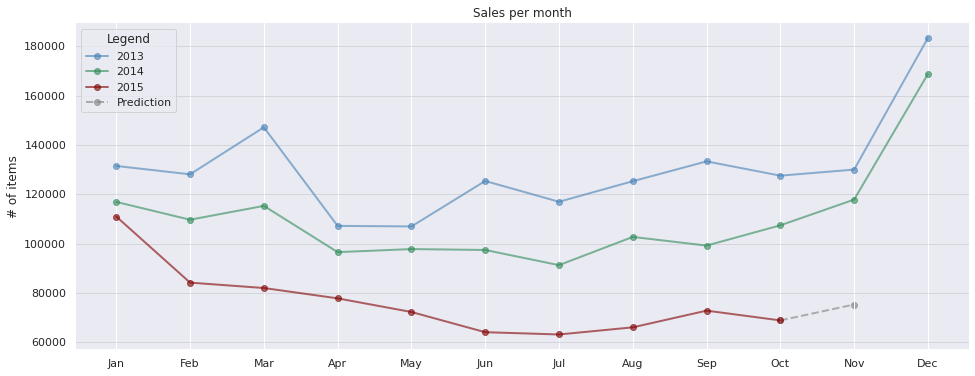

In [20]:
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
LINEWIDTH=2
ALPHA=.6

dfp = sales[['date', 'date_block_num','item_cnt_day']].copy()

# Extract the year and the month from the date column into indepedent columns
dfp['date']  = pd.to_datetime(dfp['date'], format='%d.%m.%Y')
dfp['year']  = dfp['date'].dt.year
dfp['month'] = dfp['date'].dt.month
dfp.drop(['date'], axis=1, inplace=True)

# Sum the number of sold items for each date_block_num (which is the consecutive month number from January 2013 to October 2015)
dfp = dfp.groupby('date_block_num', as_index=False).agg({'year':'first', 'month':'first', 'item_cnt_day':'sum'}).rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=False)
print(dfp)
plt.figure(figsize=(16,6))
# Plot the sales of the year 2013
plt.plot(MONTHS, dfp[dfp.year==2013].item_cnt_month, '-o', color='steelblue', linewidth=LINEWIDTH, alpha=ALPHA,label='2013')

# Plot the sales of the year 2014
plt.plot(MONTHS, dfp[dfp.year==2014].item_cnt_month, '-o', color='seagreen', linewidth=LINEWIDTH, alpha=ALPHA,label='2014')

# Plot the sales of the year 2015 until October
plt.plot(MONTHS[:10], dfp[dfp.year==2015].item_cnt_month, '-o', color='maroon', linewidth=LINEWIDTH, alpha=ALPHA,label='2015')

# Capturing the trend between October and November (For year 2013 and 2014)
delta_2013 = dfp.iloc[10].item_cnt_month - dfp.iloc[9].item_cnt_month
delta_2014 = dfp.iloc[22].item_cnt_month - dfp.iloc[21].item_cnt_month
avg_delta = (delta_2013 + delta_2014) / 2
# Add the average to the previous month (October 2015)
nov_2015 = dfp.iloc[33].item_cnt_month + avg_delta

# MONTHS[9:11] equals ['Oct', 'Nov']
plt.plot(MONTHS[9:11], [dfp.iloc[33].item_cnt_month, nov_2015], '--o', color='gray', linewidth=LINEWIDTH, alpha=ALPHA, label='Prediction', zorder=-1)

# Axes parameters
ax = plt.gca()
ax.set_title('Sales per month')
ax.set_ylabel('# of items')
ax.grid(axis='y', color='gray', alpha=.2)
    
# Remove the frame off the chart
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend(loc=2, title='Legend')
# plt.show()

del dfp


In [21]:
#Remove negative values

In [22]:
median = sales[(sales.shop_id==32)&(sales.item_id==2973)&(sales.date_block_num==4)&(sales.item_price>0)].item_price.median()
sales.loc[sales.item_price<0, 'item_price'] = median

In [23]:
#Checking duplicate shop names by manual inspection.
shops[shops["shop_id"].isin([10, 11])]

,shop_name,shop_id
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11


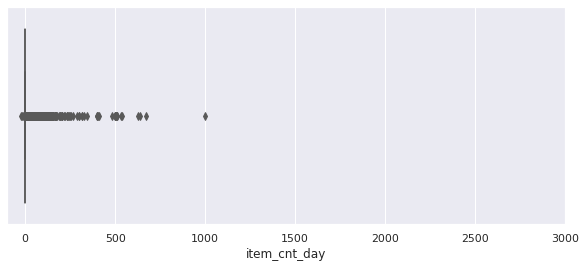

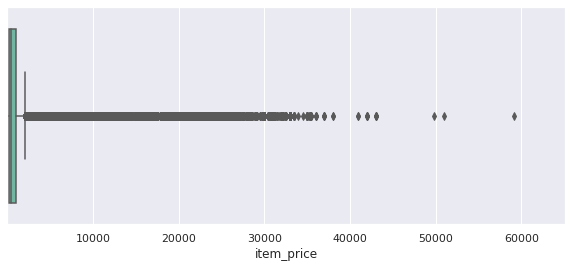

In [24]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
# sns.set_theme(style="whitegrid")
sns.boxplot(x=sales.item_cnt_day,palette="Set2")

plt.figure(figsize=(10,4))
plt.xlim(sales.item_price.min(), sales.item_price.max()*1.1)
sns.boxplot(x=sales.item_price,palette="Set2")

In [25]:
#Fixing the sales data by removing the duplicate data after manually inspecting the data.
sales.loc[sales.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
sales.loc[sales.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
sales.loc[sales.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11
sales.loc[sales.shop_id == 23, 'shop_id'] = 24
test.loc[test.shop_id == 23, 'shop_id'] = 24

In [26]:
#Join data sets
edaSale  = sales.copy() 
edaItem = items.copy()
edaShops = shops.copy()
edaCat = cats.copy()

edaData = edaSale.join(edaItem, on='item_id', rsuffix='_').join(edaShops, on='shop_id', rsuffix='_').join(edaCat, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [27]:
# Select only useful features.
edaData_monthly = edaData[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [28]:
# Group by month in this case "date_block_num" and aggregate features.
edaData_monthly = edaData_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
edaData_monthly = edaData_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features for EDA of the data 
edaData_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [29]:
# Extract time based features.
edaData_monthly['year'] = edaData_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
edaData_monthly['month'] = edaData_monthly['date_block_num'].apply(lambda x: (x % 12))

In [30]:
# Grouping data for EDA.
gp_month_mean = edaData_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = edaData_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = edaData_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = edaData_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = edaData_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = edaData_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

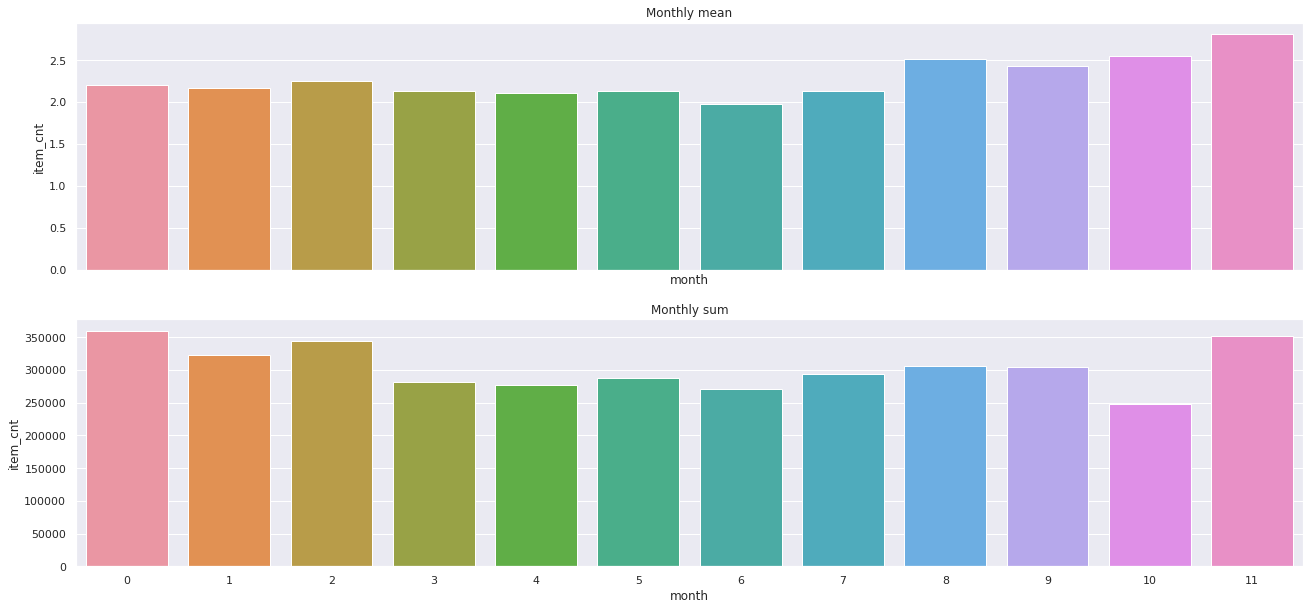

In [31]:
#Check sales along the year
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.barplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

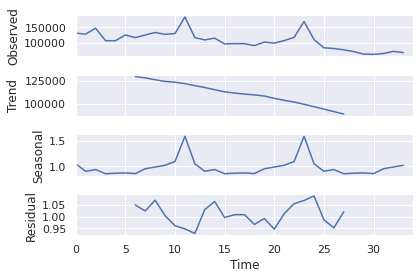

In [32]:
#Decomposing data for trend
import statsmodels.api as sm
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()


In [33]:
#Adding city code and type code

In [34]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [35]:
#Creating matrix for data preprocessing
from itertools import product
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales_info = sales[sales.date_block_num==i]
    matrix.append(np.array(list(product([i], sales_info.shop_id.unique(), sales_info.item_id.unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix.sort_values(cols,inplace=True)

In [36]:
#Calculating monthly sales for each shop and item Id
group = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

In [37]:
#Adding new column to the matrix
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

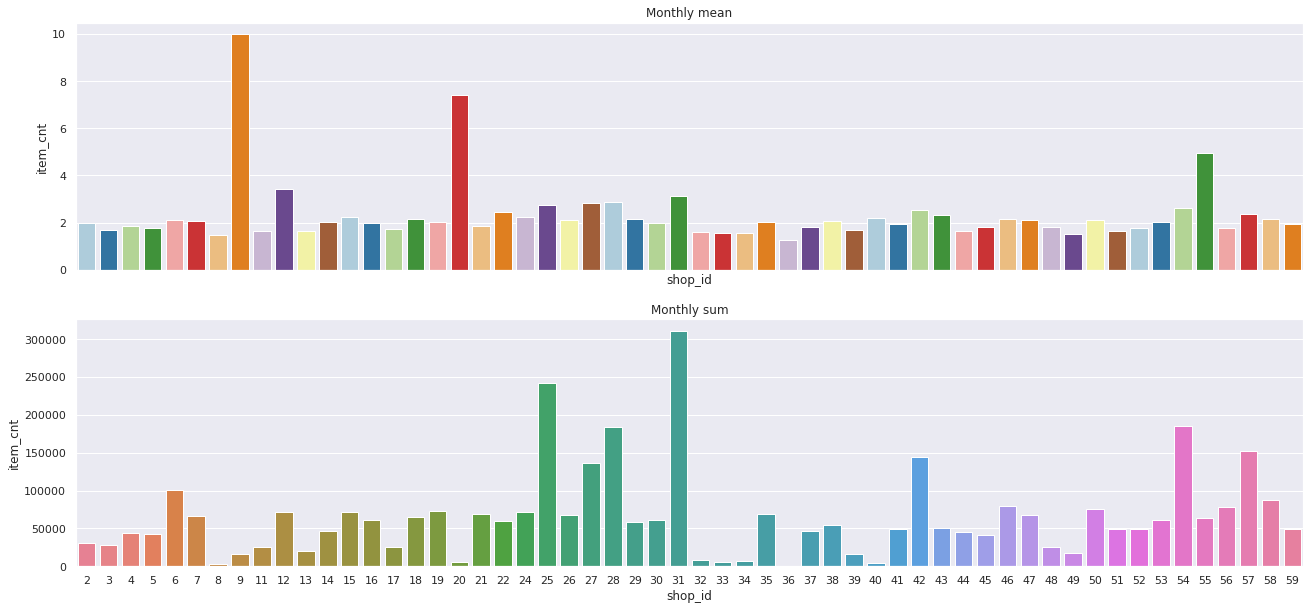

In [38]:
#Checking Shop sales
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="Paired").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="husl").set_title("Monthly sum")
plt.show()

In [39]:
#test set
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)


In [40]:
#Merging test with sales in order to genearate new features for all of them.
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month


In [41]:
#Feature Extraction - Merging city_code, item_category_id, type code and subtype_code to main matrix
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [42]:
#Adding lag feature for the target.
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [43]:
#Adding lag to add item_cnt-month for last one month, last two month, quaterly, half yearly and annually.
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

In [44]:
#Printing the matrix to check newly added columns.
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.00,0.00,0,40,11,4,nan,nan,nan,nan,nan
1,0,2,27,1.00,0.00,0,19,5,10,nan,nan,nan,nan,nan
2,0,2,28,0.00,0.00,0,30,8,55,nan,nan,nan,nan,nan
3,0,2,29,0.00,0.00,0,23,5,16,nan,nan,nan,nan,nan
4,0,2,32,0.00,0.00,0,40,11,4,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11095269,34,45,18454,0.00,214195.00,20,55,13,2,1.00,0.00,0.00,0.00,nan
11095270,34,45,16188,0.00,214196.00,20,64,14,42,0.00,0.00,nan,nan,nan
11095271,34,45,15757,0.00,214197.00,20,55,13,2,0.00,0.00,0.00,0.00,0.00
11095272,34,45,19648,0.00,214198.00,20,40,11,4,0.00,0.00,0.00,0.00,nan


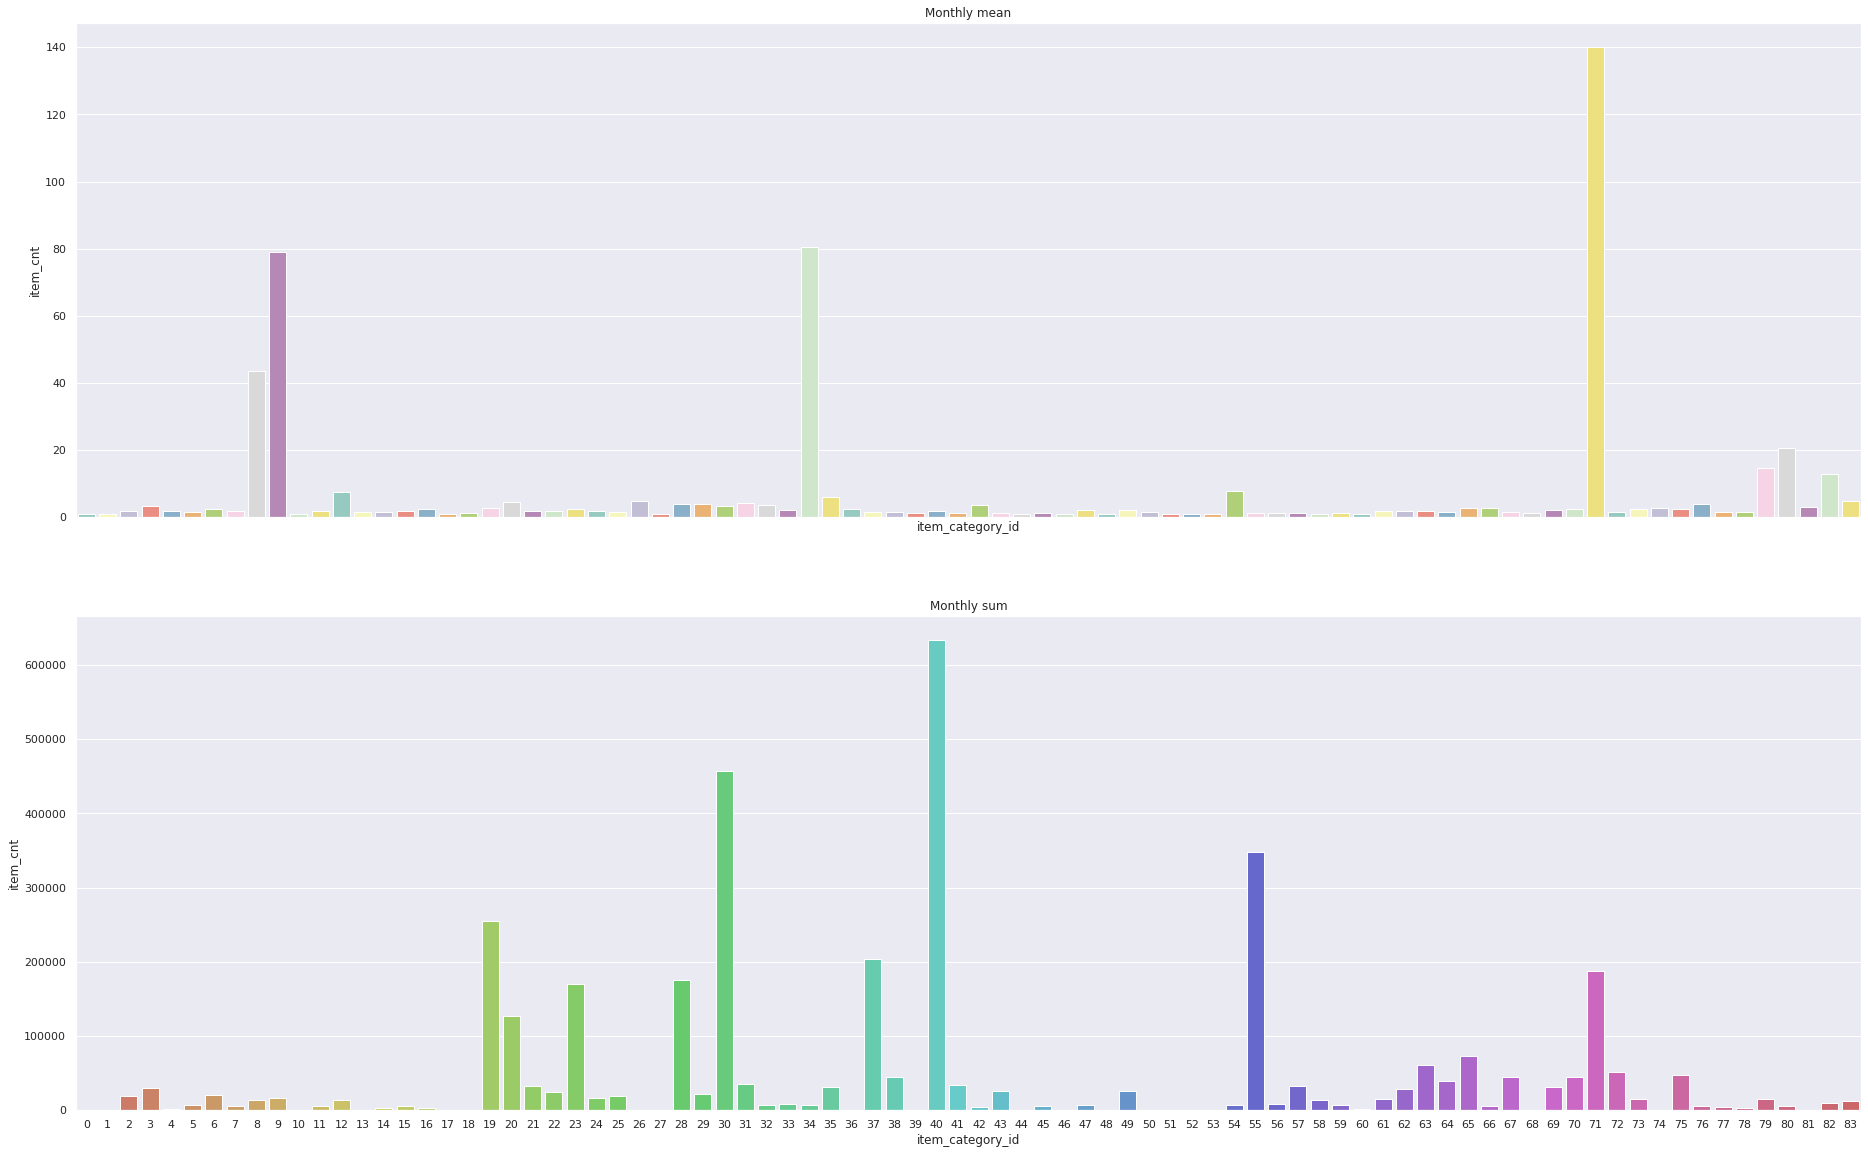

In [45]:
#Check categories of sales along the year
f, axes = plt.subplots(2, 1, figsize=(32, 20), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="Set3").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="hls").set_title("Monthly sum")
plt.show()

In [46]:
#Feature Engineering : Adding Mean Encoding Feature for Month and item_cnt_cnt. .i.e. date_avg_item_cnt
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [47]:
#Feature Engineering : Adding Mean Encoding Feature for Month, itemid and item_cnt_cnt. .i.e. date_item_avg_item_cnt
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')#
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [48]:
#Feature Engineering : Adding Mean Encoding Feature for Month, shopid  and item_cnt_cnt. .i.e. date_shop_avg_item_cnt
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [49]:
#Mean Encoding Feature - Month, category and item_cnt_cnt
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [50]:
#Feature Engineering : Adding Mean Encoding Feature for Month, item_category_id  and item_cnt_cnt. .i.e. date_shop_cat_avg_item_cnt
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [51]:
#Feature Engineering : Adding Mean Encoding Feature for  Month, City and item_cnt_cnt. .i.e. date_city_avg_item_cnt
#Mean Encoding Feature -  Month and City
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [52]:
#Mean Encoding Feature - Adding Mean Encoding Feature for  Month, itemid, City and item_cnt_cnt. .i.e. date_item_city_avg_item_cnt
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [53]:
#Mean Encoding Feature - Adding Mean Encoding Feature for itemid and item price. .i.e. item_avg_item_price
group = sales.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

In [54]:
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

In [55]:
#Mean Encoding Feature - Adding Mean Encoding Feature for month, itemid and item price. .i.e. item_avg_item_price
group = sales.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

In [56]:
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

In [57]:
#Adding lag feature for date_item_avg_item_price
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

In [58]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6
0,0,2,19,0.00,0.00,0,40,11,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,28.00,28.00,nan,nan,nan,nan,nan,nan
1,0,2,27,1.00,0.00,0,19,5,10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1461.00,2324.00,nan,nan,nan,nan,nan,nan
2,0,2,28,0.00,0.00,0,30,8,55,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,310.00,549.00,nan,nan,nan,nan,nan,nan
3,0,2,29,0.00,0.00,0,23,5,16,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1759.00,2398.00,nan,nan,nan,nan,nan,nan
4,0,2,32,0.00,0.00,0,40,11,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,249.62,338.00,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11095269,34,45,18454,0.00,214195.00,20,55,13,2,1.00,0.00,0.00,0.00,nan,0.26,0.05,0.02,0.07,0.59,nan,0.13,0.13,0.14,0.14,nan,0.20,0.13,0.14,0.50,188.62,nan,99.00,99.00,99.00,99.00,98.94,199.00
11095270,34,45,16188,0.00,214196.00,20,64,14,42,0.00,0.00,nan,nan,nan,0.26,0.02,0.07,nan,nan,nan,0.13,0.13,nan,nan,nan,0.16,0.09,0.14,0.00,1257.00,nan,1359.00,1223.00,nan,nan,nan,nan
11095271,34,45,15757,0.00,214197.00,20,55,13,2,0.00,0.00,0.00,0.00,0.00,0.26,0.11,0.07,0.10,0.25,0.18,0.13,0.13,0.14,0.14,0.18,0.20,0.13,0.14,0.00,198.12,nan,229.00,229.00,229.00,229.00,229.00,208.12
11095272,34,45,19648,0.00,214198.00,20,40,11,4,0.00,0.00,0.00,0.00,nan,0.26,0.05,0.07,0.17,0.09,nan,0.13,0.13,0.14,0.14,nan,0.22,0.08,0.14,0.00,98.12,nan,89.12,99.00,94.88,99.00,99.00,99.00


In [59]:
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']


In [60]:
#Extracting trends
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [61]:
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

In [62]:
#Dropping the price feature after the trend.
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [63]:
#Mean Encoding Feature - Adding Mean Encoding Feature for month, shopid and revenue. .i.e. item_avg_item_price
group = sales.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

In [64]:
#Mean Encoding Feature - Adding Mean Encoding Feature for  shopid and date_shop_revenue. .i.e. item_avg_item_price
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

In [65]:
matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

In [66]:
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

In [67]:
matrix = lag_feature(matrix, [1], 'delta_revenue')
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [68]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
0,0,2,19,0.00,0.00,0,40,11,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan
1,0,2,27,1.00,0.00,0,19,5,10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan
2,0,2,28,0.00,0.00,0,30,8,55,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan
3,0,2,29,0.00,0.00,0,23,5,16,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan
4,0,2,32,0.00,0.00,0,40,11,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11095269,34,45,18454,0.00,214195.00,20,55,13,2,1.00,0.00,0.00,0.00,nan,0.26,0.05,0.02,0.07,0.59,nan,0.13,0.13,0.14,0.14,nan,0.20,0.13,0.14,0.50,-0.48,-0.29
11095270,34,45,16188,0.00,214196.00,20,64,14,42,0.00,0.00,nan,nan,nan,0.26,0.02,0.07,nan,nan,nan,0.13,0.13,nan,nan,nan,0.16,0.09,0.14,0.00,0.08,-0.29
11095271,34,45,15757,0.00,214197.00,20,55,13,2,0.00,0.00,0.00,0.00,0.00,0.26,0.11,0.07,0.10,0.25,0.18,0.13,0.13,0.14,0.14,0.18,0.20,0.13,0.14,0.00,0.16,-0.29
11095272,34,45,19648,0.00,214198.00,20,40,11,4,0.00,0.00,0.00,0.00,nan,0.26,0.05,0.07,0.17,0.09,nan,0.13,0.13,0.14,0.14,nan,0.22,0.08,0.14,0.00,-0.09,-0.29


In [69]:
#Extracting the month feature
matrix['month'] = matrix['date_block_num'] % 12

In [70]:
#Extracting the days feature
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [71]:
#Extracting the item_shop_last_sale feature
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num  

In [72]:
#Extracting the item_last_sale feature
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num       

In [73]:
#Extracting the item_first_sale feature
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

In [74]:
#removing 1st 12 months
matrix = matrix[matrix.date_block_num > 11]

In [75]:
#Adding null
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [76]:
#Setting the data for the Model training.
data = matrix[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [77]:
#Spliting the Train, validation and test
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [78]:
del data

In [79]:
#XGBoost Regressor Model Implementation.

In [80]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[00:43:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:43:41] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.15123	validation_1-rmse:1.11693
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10717	validation_1-rmse:1.08397
[2]	validation_0-rmse:1.06633	validation_1-rmse:1.05305
[3]	validation_0-rmse:1.03158	validation_1-rmse:1.02736
[4]	validation_0-rmse:1.00475	validation_1-rmse:1.00853
[5]	validation_0-rmse:0.979663	validation_1-rmse:0.990091
[6]	validation_0-rmse:0.958649	validation_1-rmse:0.975133
[7]	validation_0-rmse:0.939311	validation_1-rmse:0.961287
[8]	validation_0-rmse:0.92413	validation_1-rms

XGBRegressor(colsample_bytree=0.8, eta=0.3, max_depth=8, min_child_weight=300,
             n_estimators=1000, seed=42, subsample=0.8)

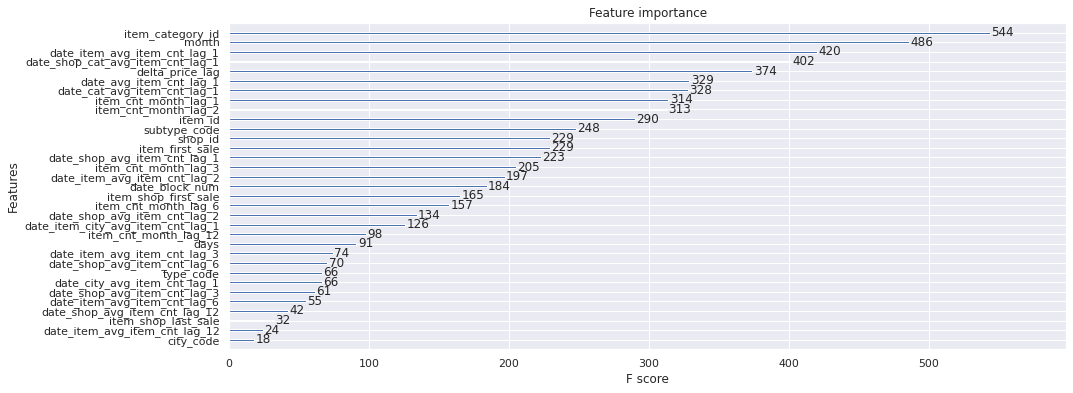

In [81]:
#Checking the importance of the features.
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(model)
plt.show()

In [82]:
#predicting the sale forcast from training, validation and testing data. 
#Clipping the prediction count from 0-20 
Y_train_pred = model.predict(X_train).clip(0, 20)
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

In [83]:
#Generating submission  csv for the XGBoost model
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission1.csv', index=False)


In [84]:
#Getting RMSE score for XGboost
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, Y_pred)))

Train rmse: 0.82488465
Validation rmse: 0.9061621


In [85]:
#Getting RMSLE score
print('Training rmsle:', np.sqrt(mean_squared_log_error(Y_valid, Y_pred)))
print('Validation rmsle:', np.sqrt(mean_squared_log_error(Y_valid, Y_pred)))

Training rmsle: 0.30314052
Validation rmsle: 0.30314052


In [86]:
#Getting MAE score
print('Train mae:', mean_absolute_error(Y_train, Y_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid, Y_pred))

Train mae: 0.3116245
Validation mae: 0.3158552


In [87]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.regplot(y="Label", x="Prediction", data=performance_df, color="g")
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()

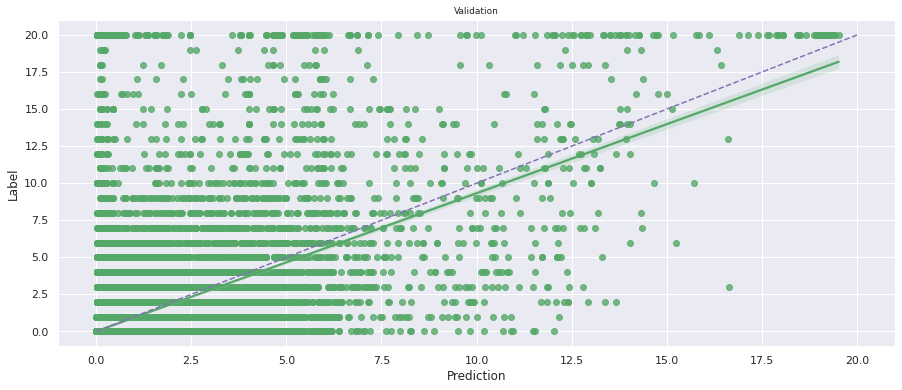

In [88]:
#plotting the projected values by the model and the true values.
model_performance_sc_plot(Y_pred, Y_valid, 'Validation')

In [89]:
#Random Forest Model Implementation.

In [90]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=-1, random_state=0)

In [91]:
#predicting the sale forcast from training, validation and testing data. 
rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_valid)
rf_test_pred = rf_model.predict(X_test)

In [92]:
#Getting RMSE score for Random Forest
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, rf_val_pred)))

Train rmse: 0.8762175802846264
Validation rmse: 0.9412465053955391


In [93]:
#Getting RMSLE score
print('Training rmsle:', np.sqrt(mean_squared_log_error(Y_train, rf_train_pred)))
print('Validation rmsle:', np.sqrt(mean_squared_log_error(Y_valid, rf_val_pred)))

Training rmsle: 0.3042393764093474
Validation rmsle: 0.31314124967514506


In [94]:
#Getting MAE score for Random Forest
print('Train mae:', mean_absolute_error(Y_train, rf_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid, rf_val_pred))

Train mae: 0.3241911086508153
Validation mae: 0.31574528588596984


In [95]:
#Getting submission csv for the RF model
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": rf_test_pred
})
submission.to_csv('rf_submission1.csv', index=False)


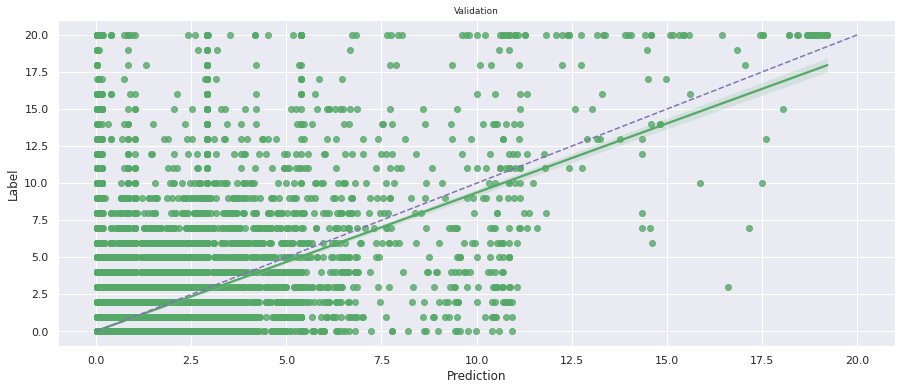

In [96]:
#plotting the projected values by the model and the true values.
model_performance_sc_plot(rf_val_pred, Y_valid, 'Validation')

In [97]:
#Linear Regression Model Implementation

In [98]:
#Normalizing the data
lr_scaler = MinMaxScaler()
lr_scaler.fit(X_train)
lr_train = lr_scaler.transform(X_train)
lr_val = lr_scaler.transform(X_valid)
lr_test = lr_scaler.transform(X_test)

In [99]:
#trainoing the model
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(n_jobs=-1)

In [100]:
#predicting the sale forcast from training, validation and testing data. 
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [101]:
#Getting RMSE score for Linear Regression
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lr_val_pred)))

Train rmse: 0.9168681
Validation rmse: 0.9635804


In [102]:
#Getting MAE score for Linear Regression
print('Train mae:', mean_absolute_error(Y_train, lr_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid, lr_val_pred))

Train mae: 0.34837243
Validation mae: 0.36626872


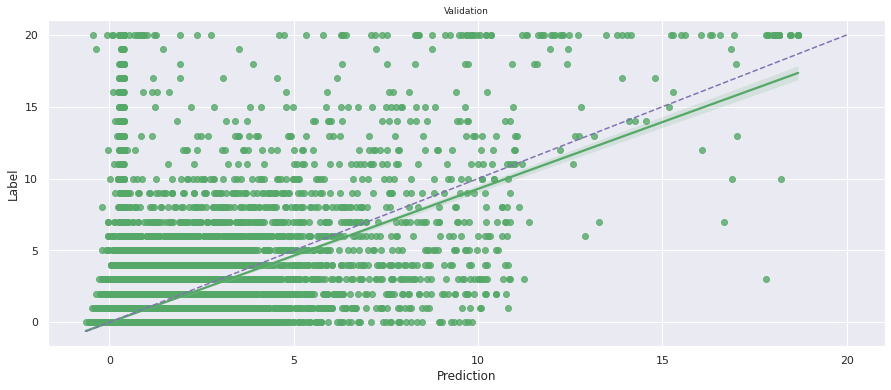

In [103]:
#plotting the projected values by the model and the true values.
model_performance_sc_plot(lr_val_pred, Y_valid, 'Validation')

In [104]:
#Getting submission csv for the LR model
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": lr_test_pred
})
submission.to_csv('lr_submission1.csv', index=False)

In [105]:
#LSTM model Implementation

In [106]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout

In [107]:
#Reshaping the Data for LSTM Model
X_train1=X_train.values.reshape((X_train.shape[0],X_train.shape[1],1))
X_valid1=X_valid.values.reshape((X_valid.shape[0],X_valid.shape[1],1))

Y_train1=Y_train.values.reshape((Y_train.shape[0],1))
Y_valid1=Y_valid.values.reshape((Y_valid.shape[0],1))

X_test1=X_test.values.reshape((X_test.shape[0],X_test.shape[1],1))

In [108]:
#Buidling the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(X_train1.shape[1], X_train1.shape[2]),return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(8))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 34, 16)            1152      
                                                                 
 dropout (Dropout)           (None, 34, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 7,697
Trainable params: 7,697
Non-trainabl

In [109]:
#Buidling the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(X_train1.shape[1], X_train1.shape[2]),return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(8))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 34, 16)            1152      
                                                                 
 dropout_2 (Dropout)         (None, 34, 16)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                6272      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 7,697
Trainable params: 7,697
Non-traina

Epoch 1/10
3021/3021 [==============================] - 42s 12ms/step - loss: 0.9408 - mse: 0.9408 - val_loss: 0.9279 - val_mse: 0.9279
Epoch 2/10
3021/3021 [==============================] - 34s 11ms/step - loss: 0.8782 - mse: 0.8782 - val_loss: 0.9363 - val_mse: 0.9363
Epoch 3/10
3021/3021 [==============================] - 34s 11ms/step - loss: 0.8638 - mse: 0.8638 - val_loss: 0.9089 - val_mse: 0.9089
Epoch 4/10
3021/3021 [==============================] - 34s 11ms/step - loss: 0.8488 - mse: 0.8488 - val_loss: 0.9147 - val_mse: 0.9147
Epoch 5/10
3021/3021 [==============================] - 34s 11ms/step - loss: 0.8353 - mse: 0.8353 - val_loss: 0.8847 - val_mse: 0.8847
Epoch 6/10
3021/3021 [==============================] - 34s 11ms/step - loss: 0.8266 - mse: 0.8266 - val_loss: 0.8744 - val_mse: 0.8744
Epoch 7/10
3021/3021 [==============================] - 34s 11ms/step - loss: 0.8180 - mse: 0.8180 - val_loss: 0.8740 - val_mse: 0.8740
Epoch 8/10
3021/3021 [==========================

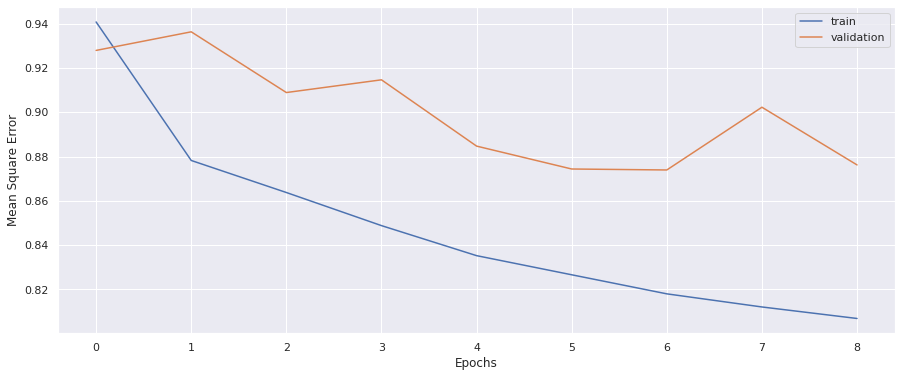

<Figure size 1080x432 with 0 Axes>

In [110]:
#Training the LSTM model
from keras.callbacks import EarlyStopping
LSTM_PARAM = {"batch_size":2048,
              "verbose":1,
              "epochs":10}

    
callbacks_list=[EarlyStopping(monitor="val_loss",min_delta=.001, patience=3,mode='auto')]
hist = model_lstm.fit(X_train1, Y_train1,validation_data=(X_valid1, Y_valid1),callbacks=callbacks_list, **LSTM_PARAM)
lstm_prediction = model_lstm.predict(X_test1)

# Model Evaluation
best = np.argmin(hist.history["val_loss"])
print("Optimal Epoch: {}",best)
print("Train Score: {}, Validation Score: {}".format(hist.history["loss"][best],hist.history["val_loss"][best]))

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Mean Square Error")
plt.legend()
plt.show()
plt.savefig("Train and Validation MSE Progression.png")

In [111]:
#predicting the sale forcast from training, validation and testing data. 
lstm_valid_pred = model_lstm.predict(X_valid1)
lstm_train_pred = model_lstm.predict(X_train1)
lstm_test_pred = model_lstm.predict(X_test1)

In [112]:
lstm_test_pred

array([[0.78342277],
       [0.40096357],
       [1.1110218 ],
       ...,
       [0.03406972],
       [0.02638279],
       [0.05323583]], dtype=float32)

In [139]:
lstm_test_predb = lstm_test_pred

In [140]:
len(lstm_test_predb)

214200

In [141]:
len(test.index)

214200

In [143]:
np.concatenate(lstm_test_predb)
len(lstm_test_predb)

214200

In [144]:
type(lstm_test_predb)

numpy.ndarray

In [153]:
lstm_test_predb = lstm_test_predb.flatten()
print(lstm_test_predb)

[0.78342277 0.40096357 1.1110218  ... 0.03406972 0.02638279 0.05323583]


In [155]:
#Getting RMSE score for LSTM model
print('Train rmse:', np.sqrt(mean_squared_error(Y_train1, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid1, lstm_valid_pred)))

Train rmse: 0.8772484
Validation rmse: 0.93607426


In [156]:
#Getting MAE score for LSTM model
print('Train mae:', mean_absolute_error(Y_train1, lstm_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid1, lstm_valid_pred))

Train mae: 0.31499958
Validation mae: 0.3171664


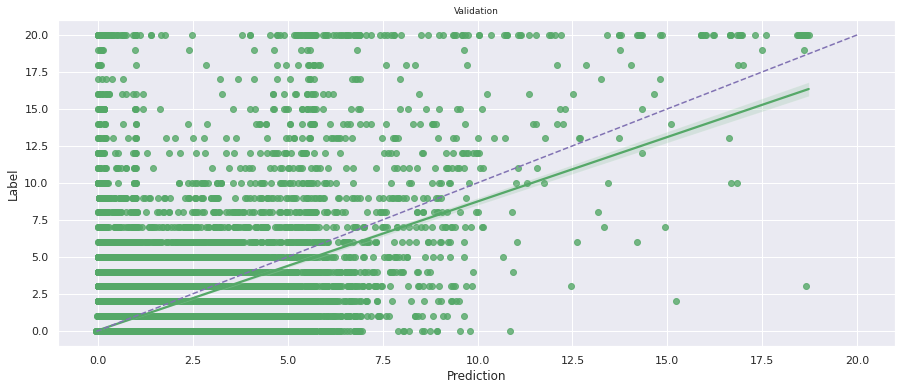

In [157]:
#plotting the projected values by the model and the true values.
model_performance_sc_plot(lstm_valid_pred, Y_valid, 'Validation')

In [154]:
#Generating submission csv for kaggle
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": lstm_test_predb
})
submission.to_csv('lstm_test_pred.csv', index=False)

In [158]:
#Trying Ensemble method for regression

In [163]:
#building the first model based on the validation predictions of the all the models
first_level_validation = pd.DataFrame(Y_pred, columns=['xgbm'])
first_level_validation['lstm'] = lstm_valid_pred
first_level_validation['random_forest'] = rf_val_pred
first_level_validation['linear_regression'] = lr_val_pred
first_level_validation.head(20)

,xgbm,lstm,random_forest,linear_regression
0,0.05,0.02,0.08,-0.14
1,0.12,0.05,0.22,-0.20
2,0.24,0.31,0.07,0.09
3,0.26,0.19,0.22,0.38
4,0.03,-0.02,0.02,0.04
5,0.03,0.00,0.02,-0.04
6,0.03,0.01,0.02,-0.07
7,0.02,0.01,0.02,-0.08
8,0.02,0.01,0.02,-0.09
9,0.05,0.02,0.08,-0.11


In [164]:
#building the first model based on the test predictions of the all the models
first_level_test = pd.DataFrame(Y_test, columns=['xgbm'])
first_level_test['lstm'] = lstm_test_predb
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test.head()

,xgbm,lstm,random_forest,linear_regression
0,0.69,0.78,0.37,0.48
1,0.35,0.40,0.57,0.37
2,1.19,1.11,0.71,1.15
3,0.52,0.42,0.53,0.30
4,3.86,4.74,2.92,0.40


In [165]:
#adding the LR as second level
meta_model = LinearRegression(n_jobs=-1)

In [166]:
#first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level_validation, Y_valid)

LinearRegression(n_jobs=-1)

In [168]:
ensemble_pred = meta_model.predict(first_level_validation)
final_predictions = meta_model.predict(first_level_test)

In [169]:
#Getting RMSE score for ensemble model
print('validation rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_valid)))

validation rmse: 0.9020689853948427


In [170]:
#Getting MAE score for ensemble model
print('Validation mae:', mean_absolute_error(ensemble_pred, Y_valid))

Validation mae: 0.3117409374624392


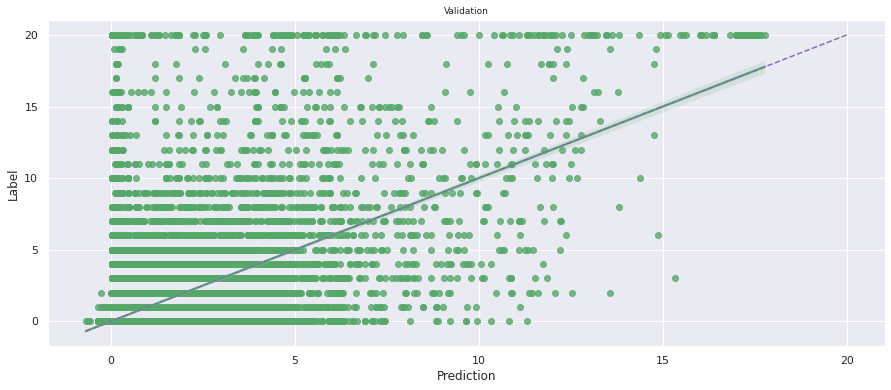

In [171]:
#plotting the projected values by the model and the true values.
model_performance_sc_plot(ensemble_pred, Y_valid, 'Validation')

In [172]:
#Getting the submission Csv for the ensemble model.
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('ensemble_submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,0.73
1,1,0.25
2,2,1.25
3,3,0.45
4,4,3.70
5,5,0.76
6,6,0.82
7,7,0.11
8,8,1.08
9,9,0.70
